In [189]:
import pandas as pd
import numpy as np
import ast

from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict

import random
import shap

In [190]:
def classification_performance(X, y, model):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    predictions = cross_val_predict(model, X_scaled, y, cv=3)
    print(classification_report(y, predictions))
    
    return predictions

In [191]:
speaker_df = pd.read_csv("data/annotated_dataset/speaker_data.csv", sep=",", encoding="utf-8")

In [192]:
X_tfidf = speaker_df["tfidf"]
X_tfidf = np.array([ast.literal_eval(item) for item in X_tfidf])

y_pop = np.vstack(speaker_df["pop_sum"].values)
y_pol = np.vstack(speaker_df["polarization"].values)

y_pol = [0 if x <= 0.75 else 1 if x<=1.45 else 2 for x in y_pol]
y_pop = [0 if x < 1 else 1 for x in y_pop]

Ci sono 714 features: 300 di valori medi di tfidf dei testi (con dimensionality reduction) + 57 di valori medi di feature interpretabili + 300 di std di tfidf dei testi + 57 di std di feature interpretabili

In [193]:
interpretable_feats = ['parte','molto','lavoro','quando','anni','provvedimento','solo','prima','ancora','presidente','paese','legge','signor','governo','poi','fatto','italia','politica','commissione','già','stato','oggi','articolo','essere','ministro','quindi','fare','decreto','stars','score','neutral','approval','annoyance','realization','disapproval','confusion','disappointment','admiration','anger','disgust','amusement','optimism','excitement','sadness','joy','curiosity','fear','surprise','love','caring','gratitude','embarrassment','desire','grief','pride','relief','nervousness']
feature_names = ["f"+str(i) for i in range(300)] + [x+"_avg" for x in interpretable_feats] + ["f"+str(i) for i in range(358, 658)] + [x+"_std" for x in interpretable_feats]

In [198]:
def SHAP_analysis(X, y, n_classes):
    svc = LinearSVC(dual=False, max_iter=10000, C=0.1, class_weight='balanced', loss='squared_hinge', penalty= 'l1')
    y_pred = classification_performance(X, y, svc)
    
    misclassified_indices = np.where(y_pred != y)[0]
    correctly_classified_indices = np.where(y_pred == y)[0]
    
    X = pd.DataFrame(X, columns = feature_names)
    
    random.seed(42)
    misclassified_instance = X.iloc[random.choice(misclassified_indices)].to_frame().T if len(misclassified_indices) > 0 else None
    correctly_classified_instance = X.iloc[random.choice(correctly_classified_indices)].to_frame().T if len(correctly_classified_indices) > 0 else None
    
    model = LinearSVC(dual=False, max_iter=10000, C=0.1, class_weight='balanced', loss='squared_hinge', penalty= 'l1')
    model.fit(X, y)
    
    explainer = shap.Explainer(model, X)
    
    if misclassified_instance is not None:
        shap_values_misclassified = explainer(misclassified_instance)
        print("Classificazione errata:")
        if n_classes==2:
            shap.waterfall_plot(shap_values_misclassified[0], max_display=12)
        else:
            shap.waterfall_plot(shap_values_misclassified[0][:, np.argmax(model.predict(misclassified_instance))], max_display=12)

    if correctly_classified_instance is not None:
        shap_values_correct = explainer(correctly_classified_instance)
        print("Classificazione corretta:")
        if n_classes==2:
            shap.waterfall_plot(shap_values_correct[0], max_display=12)
        else:
            shap.waterfall_plot(shap_values_correct[0][:, np.argmax(model.predict(correctly_classified_instance))], max_display=12)

              precision    recall  f1-score   support

           0       0.77      0.81      0.79       214
           1       0.86      0.82      0.84       293

    accuracy                           0.82       507
   macro avg       0.81      0.82      0.81       507
weighted avg       0.82      0.82      0.82       507

Classificazione errata:


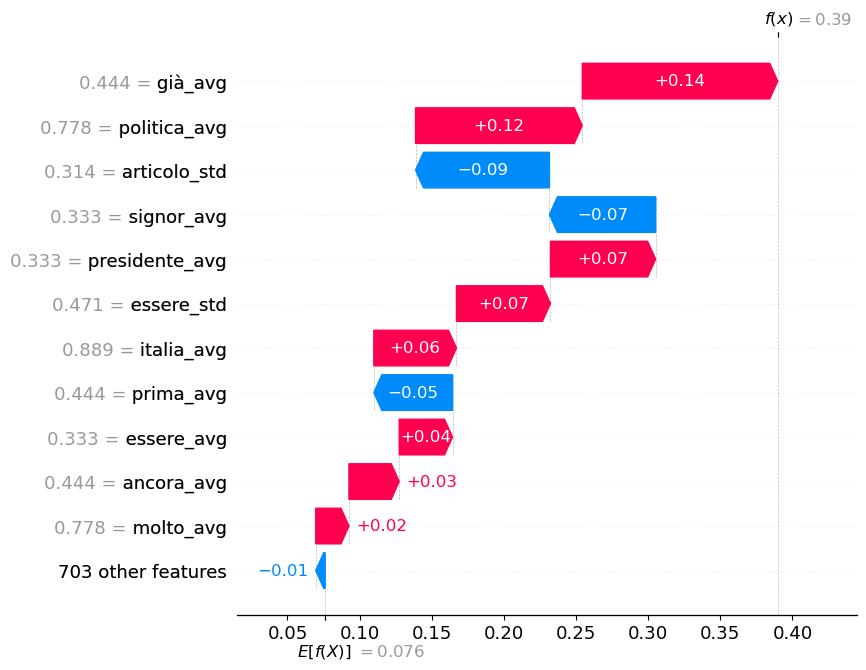

Classificazione corretta:


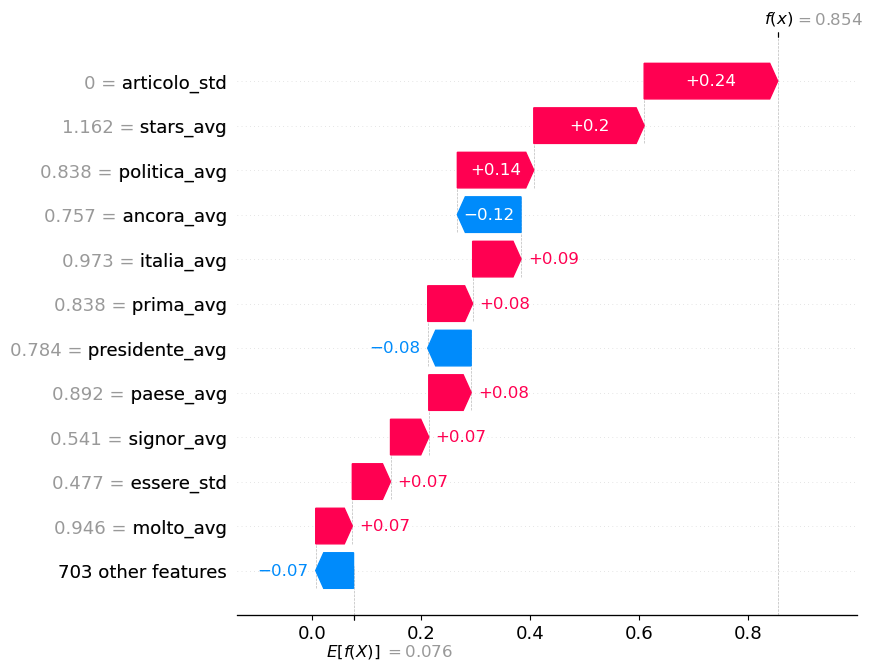

In [199]:
SHAP_analysis(X_tfidf, y_pop, 2)

              precision    recall  f1-score   support

           0       0.70      0.65      0.68       121
           1       0.73      0.75      0.74       207
           2       0.81      0.82      0.81       179

    accuracy                           0.75       507
   macro avg       0.75      0.74      0.74       507
weighted avg       0.75      0.75      0.75       507

Classificazione errata:


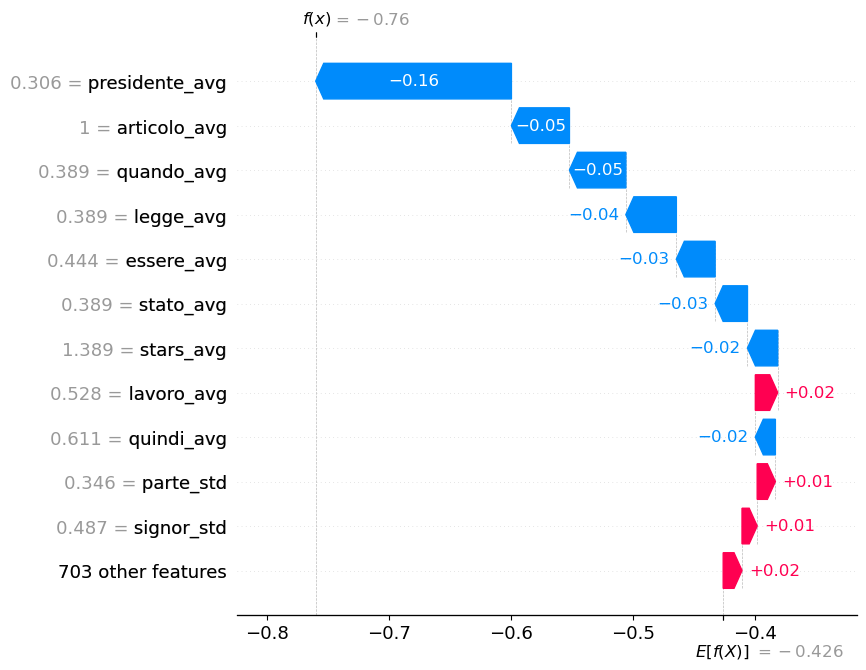

Classificazione corretta:


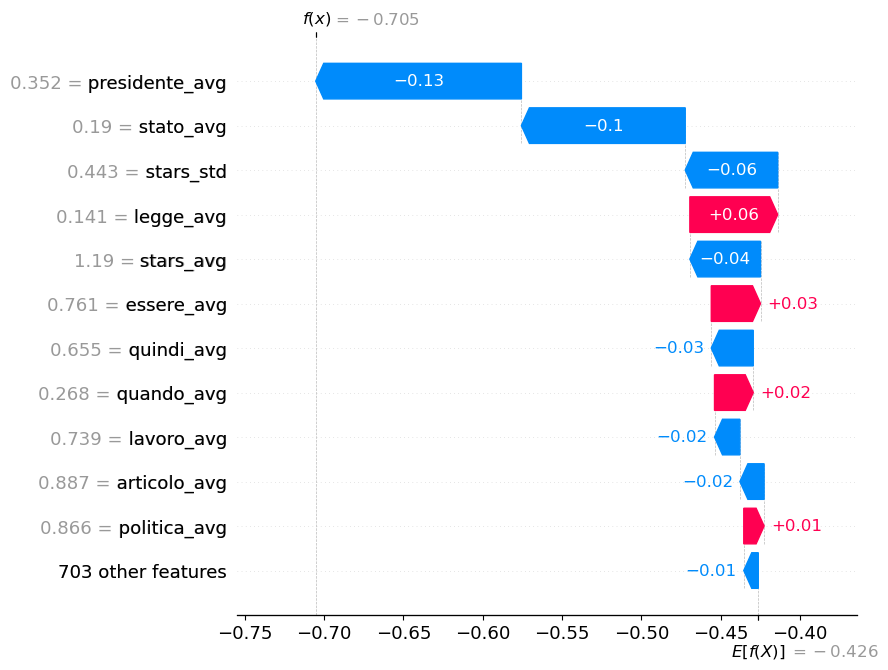

In [200]:
SHAP_analysis(X_tfidf, y_pol, 3)